# Using GEE with 'eemont'


## Description

eemont is a python library that makes working on Google Earth Engine easier. The eemont package extends the Google Earth Engine Python API with pre-processing and processing tools for the most used satellite platforms by adding utility methods for different Earth Engine Objects that are friendly with the Python method chaining.

The documentation for eemont is here: https://eemont.readthedocs.io/en/latest/

There are many tutorials you can follow here: https://eemont.readthedocs.io/en/latest/tutorials.html

## Load packages

Import Python packages that are used for the analysis.


In [1]:
%matplotlib inline

import geemap as gmap
import ee
import eemont

### Connect to Google Earth Engine (GEE)

In [2]:
m = gmap.Map()

***

## How to load a Sentinel 2 image collection using eemont

> Note the `.preprocess()` step during loading of the S2 Image Collection, it will mask the clouds and rescale the image so its ready to use

### Load sentinel-2, preprocess (mask clouds, rescale), filter by a location, and select image closest to a given date

In [3]:
Map = gmap.Map(center=[-35.2041, 149.2721], zoom=9)

# Create a point with set coordinates (canberra parliament)
point = ee.Geometry.Point([149.1244, -35.3096])
    
#load the S2 product
s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
                  .filterBounds(point) # filter to some region
                  .closest('2020-10-15') # find image closest to this date
                  .preprocess() #note this step!
     )

#after scaling, numbers are 0-1
vis_scaled = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2'],
};

# add just the first image in the collection to the map
Map.addLayer(s2, vis_scaled, 'Sentinel-2 RGB')
Map.addLayerControl()
Map

Map(center=[-35.2041, 149.2721], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

## How to load a Landsat image collection using eemont

This is the dataset: https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2

### Load Landsat 8 and filter by a location and date

In [4]:
# We give the 'center' location, and a 'zoom' level.
Map = gmap.Map(center=[-35.3096, 149.1244], zoom=9)

# Create a point with set coordinates
point = ee.Geometry.Point([149.1244, -35.3096])

# Search for a landsat 8 image collection 2
ls = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterDate('2023-07', '2023-08') #filter by images in July 2023
            .filterBounds(point)  # filter to images around parliament
            .preprocess() #mask clouds and rescale
     )

# Now we select the bands we want to display for the collection 2 image
vis_ls = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
              'min': 0,
              'max': 0.4}

# Add only the "first" image of landsat 8 image to our map
Map.addLayer(ls, vis_ls, 'Masked Landsat')
Map.addLayerControl()
Map

Map(center=[-35.3096, 149.1244], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

## Caclulate spectral indices on a sensor

In this example we will use Landsat again

Note below we import a module that allows for nice visualizations

Spectral indices comes from here: https://awesome-ee-spectral-indices.readthedocs.io/en/latest/

In [5]:
import geemap.colormaps as cm

In [6]:
# We give the 'center' location, and a 'zoom' level.
Map = gmap.Map(center=[-35.3096, 149.1244], zoom=7)

# Create a point with set coordinates
point = ee.Geometry.Point([149.1244, -35.3096])

# Search for a landsat 8 image collection 2
ls = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterDate('2023-07', '2023-10') #filter by images by date range
            .filterBounds(point)  # filter to images around parliament
            .preprocess() #mask clouds and rescale
            .spectralIndices(['NDVI','NDWI'], online=True) #compute some spectral indices
            .mean() #we'll take a temporal mean
     )

# visualization for the different indices
NDVIvis = {'min':0, 'max':1, 'palette':list(cm.palettes.ndvi), 'bands':'NDVI'}
NDWIvis = {'min':0, 'max':1, 'palette':list(cm.palettes.ndwi), 'bands':'NDWI'}

#add the layers with a colorbar
Map.addLayer(ls, NDWIvis,'NDWI')
Map.add_colorbar(NDWIvis['palette'],caption = 'NDWI')

Map.addLayer(ls,NDVIvis,'NDVI')
Map.add_colorbar(NDVIvis['palette'],caption='NDVI')

Map.addLayerControl()
Map

Map(center=[-35.3096, 149.1244], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

## Generate a time-series over a polygon (i.e., FeaturesCollections)

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

### Create a polygon using the buffer method around a point

I have chosen an irrigated paddock in NSW. The buffer method adds a radius around a point to create a polygon.

In [8]:
point = ee.Geometry.Point([149.365420, -30.220299]).buffer(200)

### Load our image collection

In [9]:
L8 = (ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
      .filterBounds(point) #filter data to the region
      .preprocess() #mask clouds and rescale image
      .spectralIndices(['EVI', 'NDWI']) #calculate indices
     ) 

### Calculate the time series

Let's get the L8 time series for our buffer. Parameters in the function:

- `Image Collection`: The Landsat 8 collection.
- `bands` to use for the time series: EVI and NDWI.
- `geometry`: Our buffered point.
- `reducer` staistics to compute over the x,y dimension: e.g. minimum, mean, maximum, median
- `scale`: Landsat resolution is 30 m.



In [10]:
ts = L8.getTimeSeriesByRegion(geometry = point,
                              bands = ['EVI','NDWI'], #which bands are we summarising?
                              reducer = [ee.Reducer.mean()], #lets take the mean of the pixels
                              scale = 30)

### Convert the time-series to a Pandas Dataframe

Note that the -9999 values are the no-data value, which we can change.

We will also change the datatype of the Date column to one pandas recognizes

In [11]:
# convert to a pandas dataframe
ts_df = gmap.ee_to_pandas(ts)

# fix the no-data value
ts_df[ts_df == -9999] = np.nan 

#convert date column to datetime
ts_df['time'] = pd.to_datetime(ts_df['date'],
                infer_datetime_format = True)

#make the index of dataframe the time stamps, and further clean up df
ts_df = ts_df.set_index('time').drop(['date', 'reducer'], axis=1)

ts_df.head() #print the top 5 rows

,EVI,NDWI
time,,
2013-04-25 23:57:02,0.072737,-0.305658
2013-05-27 23:57:20,0.062402,-0.321717
2013-06-12 23:57:16,NaN,NaN
2013-06-28 23:57:14,0.082306,-0.285553
2013-07-14 23:57:15,NaN,NaN


### Plot

Text(0.5, 1.0, 'Spectral indices time-series over an irrigated paddock in NSW')

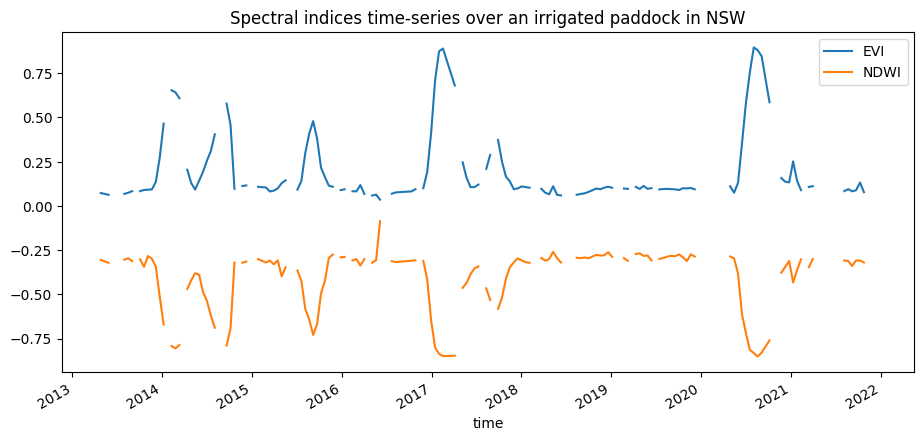

In [12]:
#now plot
ts_df.plot(figsize=(11, 5))
plt.title('Spectral indices time-series over an irrigated paddock in NSW')

***